An implementation of [Ripser: efficient computation of Vietoris-Rips persistence barcodes](https://arxiv.org/abs/1908.02518) in Julia, for computing persistent homology over Z/2Z.

In [1]:
using LinearAlgebra

In [2]:
# Simplices are represented as a descending list of their constituent vertices
# In this form, there's an isomorphism between simplices of a given dimension and the natural numbers
# This isomorphism is given by cns and inverse_cns

function binary_search_for_simplex(N, d, upper=nothing)
    if isnothing(upper)
        upper = max(d, N)
    end
    lower = 0
    mid = 0
    while upper > lower
        mid = (upper + lower) ÷ 2
        value = binomial(mid, d+1)

        if value <= N
            lower = mid + 1
        elseif value > N
            upper = mid - 1
        end
    end
    if binomial(lower, d+1) > N
        lower -= 1
    end
    lower
end

cns(indices) = sum(binomial(i, l) for (l, i) in enumerate(indices[end:-1:1]))
function inverse_cns(N, d)
    simplex = []
    limit = max(d, N)
    for dim in d:-1:0
        facet = binary_search_for_simplex(N, dim, limit)
        push!(simplex, facet)
        limit = facet
        N -= binomial(facet, dim+1)
    end
    simplex
end

inverse_cns (generic function with 1 method)

In [3]:
function pairwisedistances(A::Array{<:Real, 2})
    dists = zeros(size(A)[1], size(A)[1])
    for (i, row) in enumerate(eachrow(A))
        for (j, other) in enumerate(eachrow(A[i+1:end, :]))
            dist = norm(row - other)
            dists[i, j+i] = dist
            dists[j+i, i] = dist
        end
    end
    dists
end

function vietorisrips(points::Array{<:Real, 2}; dim_cap=5)
    #assume euclidean for now
    #and look this could be more efficient but whatever
    #and julia is col major so it's even worse but look whatever alright
    # FIXME just redo this whole thing wow
    dists = pairwisedistances(points)
    simplices = [i for i in 1:size(points)[1]]
    dimensions = [0 for i in 1:size(points)[1]]
    lifetimes = [0.0 for s in simplices] 
    
    neighbor_lookup::Dict{Int, Set{Int}} = Dict(i=>Set() for i in 1:size(points)[1])
    #simplex_lookup::Dict{Vector{Int}, Int} = Dict([i]=>i for (i,x) in enumerate(simplices))
    for dist in sort(unique(dists))
        if dist == 0.0
            continue
        end
        for (i, row) in enumerate(eachrow(dists))
            for (j, val) in enumerate(row[i+1:end])
                # AFAIK this float comparison is fine because the values all came from the same place
                if val == dist
                    # a new 1-simplex has been created
                    vertices = [i+j, i]
                    push!(simplices, cns(vertices))
                    push!(dimensions, 1)
                    push!(lifetimes, dist)
                    push!(neighbor_lookup[i], j+i)
                    push!(neighbor_lookup[j+i], i)
                    
                    to_handle = [vertices]
                    seen = Set()
                    failsafe = 0
                    while length(to_handle) > 0
                        current_vertices = pop!(to_handle)
                        if length(current_vertices) >= dim_cap
                            continue
                        elseif current_vertices ⊆ seen
                            continue
                        end
                        union!(seen, current_vertices)
                        
                        neighbors = [neighbor_lookup[x] for x in current_vertices]
                        shared = setdiff(intersect(neighbors...), current_vertices)
                        for s in shared
                            new_vertices = sort(vcat(current_vertices, [s]), rev=true)
                            
                            if length(new_vertices) - length(current_vertices) > 1
                                return
                            end
                            push!(simplices, cns(new_vertices))
                            push!(dimensions, length(new_vertices)-1)
                            push!(lifetimes, dist)
                            push!(to_handle, new_vertices)
                        end
                        failsafe += 1
                        if failsafe > 100
                            return
                        end
                    end
                end
            end
        end
    end
    simplices, dimensions, lifetimes
end

vietorisrips (generic function with 1 method)

In [4]:
# It's straightforward to enumerate all cofaces of a simplex
# Plus a bunch of boilerplate because Julia's story around generators isn't great!
# We do need an iterator because one of the ripser optimizations is to early stop this enumeration

mutable struct CofacetIterator
    simplex::Int
    dim::Int
    n::Int
    vertices::Vector{Int}
    left_sum::Int
    right_sum::Int
    k::Int
    j::Int
    function CofacetIterator(simplex::Int, dim::Int, n::Int)
        vertices = inverse_cns(simplex, dim)
        new(simplex, dim, n, vertices, 0, simplex, dim, n)
    end
end

function Base.iterate(iter::CofacetIterator)
    Base.iterate(iter, nothing)
end

function Base.iterate(iter::CofacetIterator, state)
    k = iter.k
    coface = nothing
    for j in iter.j:-1:1
        iter.j -= 1
        while k > -1 && j < iter.vertices[iter.dim - k + 1]
            iter.left_sum += binomial(iter.vertices[iter.dim - k + 1], k+2)
            iter.right_sum -= binomial(iter.vertices[iter.dim - k + 1], k+1)
            k -= 1
        end
        if k > -1 && j == iter.vertices[iter.dim - k + 1]
            continue
        end
        coface = iter.left_sum + iter.right_sum + binomial(j, k+2)
        break
    end
    iter.k = k
    if isnothing(coface)
        return nothing
    else
        return coface, iter
    end
end

In [5]:
struct Simplex
    number::Int
    dimension::Int
    diameter::Float64
end

function get_cofaces(number, dimension, total_points, available_cofaces)
    cofaces = []
    iter = CofacetIterator(number, dimension, total_points)
    for coface_number in iter
        if !(coface_number in available_cofaces)
            continue
        end
        push!(cofaces, coface_number)
    end
    cofaces
end

function find_persistent_pairs(face_simplices::Vector{Simplex}, coface_simplices::Vector{Simplex}, total_points)
    # This is Algorithm 1 in the paper
    coface_indices = Dict(c.number=>i for (i,c) in enumerate(coface_simplices))
    pairs = Tuple{Int, Int}[]
    essentials = []
    
    # NB It's pretty minor but we don't need this full matrix. Only columns for pivots matter
    # cf sec 3.4
    V = Matrix(1I, length(face_simplices), length(face_simplices)) 
    
    #{pivot=>face index}
    pivots = Dict()
    
    for (i, face) in enumerate(face_simplices)
        have_seen_maximal = false
        cofaces = Set()
        pivot = nothing
        
        iter = CofacetIterator(face.number, face.dimension, total_points)    
        for coface_number in iter
            if !haskey(coface_indices, coface_number)
                continue
            end
            # by construction this coface is already in V
            # and it is the pivot index for its face
            coface_index = coface_indices[coface_number]
            push!(cofaces, coface_index)
            if !have_seen_maximal
                if coface_simplices[coface_index].diameter == face.diameter
                    have_seen_maximal = true
                
                    if !haskey(pivots, coface_index)
                        # we're in lemma 3.3, this must be a pair
                        pivot = coface_index
                        break
                    end
                end     
            end
        end
        failsafe = 0
        if !isnothing(pivot)
            push!(pairs, (i, pivot))
            pivots[pivot] = i
            continue
        else 
            while length(cofaces) > 0
                pivot = maximum(cofaces)
                if !haskey(pivots, pivot)
                    break
                end
                owner = pivots[pivot]
                transformation = V[:,owner]
                for j in 1:owner
                    if V[j,owner] == 1
                        for other_coface_number in get_cofaces(face_simplices[j].number, face.dimension, total_points, 
                                keys(coface_indices))
                            other_coface_index = coface_indices[other_coface_number]
                            if other_coface_index in cofaces
                                pop!(cofaces, other_coface_index)
                            else
                                push!(cofaces, other_coface_index)
                            end
                        end
                    end
                end
                V[:,i] = mod.(V[:,i] + V[:,owner],2)
                failsafe += 1
                @assert failsafe < 10000
            end
        end
        if length(cofaces) == 0
            push!(essentials, i)
        else
            push!(pairs, (i, pivot))
            pivots[pivot] = i
        end
    end
    V, pairs, essentials
end

function find_pairs_with_clearing(face_simplices::Vector{Simplex}, coface_simplices::Vector{Simplex},
                                  face_pairs::Vector{Tuple{Int, Int}}, face_columns::Dict{Int, Vector{Int}},
                                  total_points::Int)
    # This is Algorithm 2
    # i know i'm doing coboundaries but the pairs are of the form (face, coface) still
    # of course in this case thats (subface, face)
    pivots = Set(j for (i,j) in face_pairs)
    original_index_lookup = Int[]
    filtered_face_simplices = Simplex[]
    for (i,s) in enumerate(face_simplices)
        if s in pivots
            continue
        end
        push!(original_index_lookup, i)
        push!(filtered_face_simplices, s)
    end
    
    face_V, coface_pairs, face_essentials = find_persistent_pairs(filtered_face_simplices, coface_simplices, 
        total_points)
                    
    # Lines 4-5 in Alg 2 are about fixing our indexing
    fixed_V = zeros(Int, length(face_simplices), length(face_simplices))
    fixed_V[original_index_lookup, original_index_lookup] = face_V
    fixed_pairs = [(original_index_lookup[f], c) for (f,c) in coface_pairs]
    fixed_essentials = [original_index_lookup[f] for f in face_essentials]
    
    for (s, f) in face_pairs
        fixed_V[:, f] = face_columns[s]
    end
    fixed_V, fixed_pairs, fixed_essentials
end


function compute_barcodes(all_simplices::Vector{Simplex}, total_points::Int)
    # One of the clever bits of ripser is that Algorithm 2 speeds up the next dimension's
    # homology computation given the pivots of the previous computation. This function ties
    # that all together into the final algorithm to compute barcodes
    
    max_dimension = maximum(s.dimension for s in all_simplices)
    dimension_pairs = []
    dimension_essentials = []
    
    dimension_partitions = [Simplex[] for d in 1:max_dimension+1]
    for s in all_simplices
        push!(dimension_partitions[s.dimension+1], s)
    end
    
    # for cohomology we need to reverse the filtration order
    dimension_partitions = [p[end:-1:1] for p in dimension_partitions]

    # H0 can be calculated faster than this
    V, pairs, essentials = find_persistent_pairs(dimension_partitions[1], dimension_partitions[2], total_points)
    push!(dimension_pairs, pairs)
    push!(dimension_essentials, essentials)
    
    for (subfaces, faces, cofaces) in zip(dimension_partitions[1:end],
                                          dimension_partitions[2:end], dimension_partitions[3:end])
        face_columns = Dict{Int,Vector{Int}}()
        available_faces = Set(s.number for s in faces)
        for (s, f) in pairs
            selected = V[:, s]
            reduced = Set()
            # iterate over all subfaces; each subface's faces are part of the reduced column for f
            for (i, v) in enumerate(selected[1:s])
                if i == 0
                    continue
                end
                for face_number in get_cofaces(subfaces[i].number, subfaces[i].dimension, total_points, available_faces)
                    if face_number in reduced
                        pop!(reduced, face_number)
                    else
                        push!(reduced, face_number)
                    end
                end
            end
            face_columns[s] = [f in reduced ? 1 : 0 for f in faces] 
        end
        
        V, pairs, essentials = find_pairs_with_clearing(faces, cofaces, pairs, face_columns, total_points)
        push!(dimension_pairs, pairs)
        push!(dimension_essentials, essentials)
    end
    
    # All we really care about are the lifetimes
    pair_lifetimes = []
    essential_lifetimes = []
    for i in 1:length(dimension_pairs)
        lifetimes = [(dimension_partitions[i][f].diameter, dimension_partitions[i+1][c].diameter) 
            for (f, c) in dimension_pairs[i]]
        push!(pair_lifetimes, lifetimes)
        
        essentials = [dimension_partitions[i][f].diameter for f in dimension_essentials[i]]
        push!(essential_lifetimes, essentials)
    end
    pair_lifetimes, essential_lifetimes
end

compute_barcodes (generic function with 1 method)

In [6]:
function lexicographic_rips(A::Array{<:Real, 2}; dim_cap=5)
    # order needs to be by lifetime, then dimension, then lexicographic
    # and we already are sorted by lifetime as a byproduct of construction
    simplices, dimensions, lifetimes = vietorisrips(A, dim_cap=dim_cap)
    function order_func(i, j)
        if lifetimes[i] == lifetimes[j]
            if dimensions[i] == dimensions[j]
                # TODO plausibly i can just compare the numbers directly since the dimensionality is the same
                #return inverse_cns(simplices[i], dimensions[i]) > inverse_cns(simplices[j], dimensions[j])
                return simplices[i] > simplices[j]
            end
            return dimensions[i] < dimensions[j]
        end
        return lifetimes[i] < lifetimes[j]
    end
    complex::Vector{Simplex} = []
    for i in sort(1:length(simplices), lt=order_func)
        push!(complex, Simplex(simplices[i], dimensions[i], lifetimes[i]))
    end
    complex
end

lexicographic_rips (generic function with 1 method)

In [7]:
Y = [0 0
     0 1
     1 0
     1 1
     4 4
     4 5
     5 4
     5 5]
complex = lexicographic_rips(Y, dim_cap=3)
pairs, essentials = compute_barcodes(complex, size(Y)[1])

for d in 1:length(pairs)
    println("Dimension $d")
    println([p for p in pairs[d] if p[1] != p[2]])
    println(essentials[d])
    println("--")
end

Dimension 1
[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 4.242640687119285), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]
[0.0]
--
Dimension 2
[(1.0, 1.4142135623730951), (1.0, 1.4142135623730951)]
[4.242640687119285, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
--


In [8]:
function sample_circle(x, y, r, n)
    points = rand(Float64, (n, 2)) .- 0.5
    points = broadcast(/, points, mapslices(norm, points, dims=2))
    points = (points .* r)
    points = broadcast(+, points, [x y])
end
points = vcat(sample_circle(0, 0, 3, 40), sample_circle(2, 2, 2, 50))
complex = lexicographic_rips(points, dim_cap=3)
pairs, essentials = compute_barcodes(complex, size(points)[1])

for d in 1:length(pairs)
    println("Dimension $d")
    println([p for p in pairs[d] if p[1] != p[2]])
    println(essentials[d])
    println("--")
end

Dimension 1
[(0.0, 0.10758331938187435), (0.0, 0.317482906237179), (0.0, 0.6125983908824939), (0.0, 0.07465633183717954), (0.0, 0.17311306579160912), (0.0, 0.5913171136843425), (0.0, 0.05877079906418833), (0.0, 0.012653673397019435), (0.0, 0.061990050016969826), (0.0, 0.25197767557988265), (0.0, 0.02108778570572438), (0.0, 0.0037115503323898137), (0.0, 0.40677372669594214), (0.0, 0.35064703436715616), (0.0, 0.04851866074745145), (0.0, 0.481806490138454), (0.0, 0.5938532466917952), (0.0, 0.3288011044114829), (0.0, 0.06453253676160549), (0.0, 0.601555044072602), (0.0, 0.19622634956997967), (0.0, 0.2093842939092325), (0.0, 0.5924384217350626), (0.0, 0.31032553296225757), (0.0, 0.692207468742537), (0.0, 0.7455838231550751), (0.0, 0.1159498153846871), (0.0, 0.024661372759123217), (0.0, 0.7963052143176736), (0.0, 0.7494914173482351), (0.0, 0.4782511690195025), (0.0, 0.9059170604240693), (0.0, 0.012919694723264735), (0.0, 0.9911064583308823), (0.0, 0.7925922428392723), (0.0, 0.833010579722193

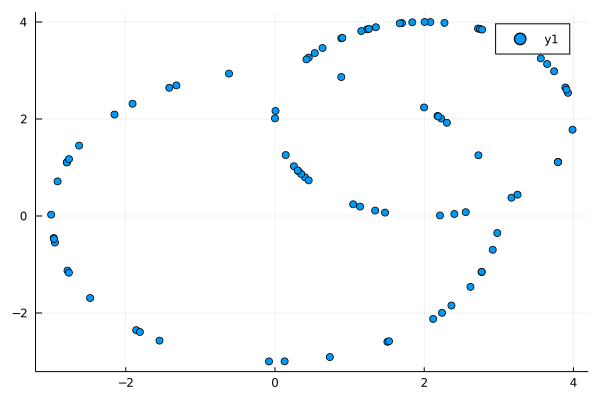

In [9]:
using Plots
scatter(points[:, 1], points[:, 2])

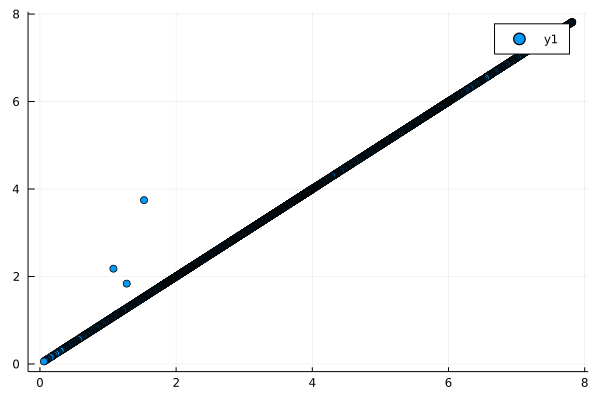

In [10]:
births = [b for (b,d) in pairs[2]]
deaths = [d for (b,d) in pairs[2]]
scatter(births, deaths)